In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pickle
from sklearn.model_selection import train_test_split
from recommenders.evaluation.python_evaluation import (
    map, ndcg_at_k, precision_at_k, recall_at_k
)
from keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import ModelCheckpoint

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [23]:
TOP_K = 10
EPOCHS = 100
BATCH_SIZE = 256
CHECKPOINT_FILEPATH = './model.weights.h5'

In [24]:
ratings = pd.read_csv('M:/Movie-Recommendation-Engine/notebooks/NCF Local/NCF/ml-1m_dataset.csv')
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

user_mapping = {user_id: idx for idx, user_id in enumerate(train_data['userID'].unique())}
item_mapping = {item_id: idx for idx, item_id in enumerate(train_data['itemID'].unique())}

train_data['userID'] = train_data['userID'].map(user_mapping)
train_data['itemID'] = train_data['itemID'].map(item_mapping)

test_data['userID'] = test_data['userID'].map(user_mapping)
test_data['itemID'] = test_data['itemID'].map(item_mapping)

test_data = test_data.copy()
test_data['userID'] = test_data['userID'].fillna(0)
test_data['itemID'] = test_data['itemID'].fillna(0)


test_data['userID'] = test_data['userID'].astype(int)
test_data['itemID'] = test_data['itemID'].astype(int)

n_users = len(user_mapping)
n_items = len(item_mapping)

print(f"Users: {n_users}, Items: {n_items}")

Users: 6040, Items: 3683


In [25]:
@register_keras_serializable(package="Custom", name="NeuralCollaborativeFiltering")
class NeuralCollaborativeFiltering(Model):
    def __init__(self, n_users, n_items, embedding_dim=8):
        super(NeuralCollaborativeFiltering, self).__init__()
        self.user_embedding = layers.Embedding(n_users, embedding_dim)
        self.item_embedding = layers.Embedding(n_items, embedding_dim)
        self.dense_layers = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs):
        user_input, item_input = inputs
        user_emb = self.user_embedding(user_input)
        item_emb = self.item_embedding(item_input)
        concatenated = tf.concat([user_emb, item_emb], axis=-1)
        return self.dense_layers(concatenated)

print("Model defined successfully.")

Model defined successfully.


No checkpoint found. Training from scratch.
Epoch 1/100
2466/2501 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.6844 - loss: 0.5869
Epoch 1: saving model to ./model.weights.h5
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6848 - loss: 0.5866 - val_accuracy: 0.7254 - val_loss: 0.5416
Epoch 2/100
2497/2501 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.7315 - loss: 0.5311
Epoch 2: saving model to ./model.weights.h5
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7315 - loss: 0.5311 - val_accuracy: 0.7300 - val_loss: 0.5334
Epoch 3/100
2482/2501 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.7378 - loss: 0.5194
Epoch 3: saving model to ./model.weights.h5
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7378 - loss: 0.5194 - val_accuracy: 0.7335 - val_loss: 0.5300
Epoch 4/100
2453/2501 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.7429 - loss: 0.5103
Epoch 4: saving model to ./model.weights.h5
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.74

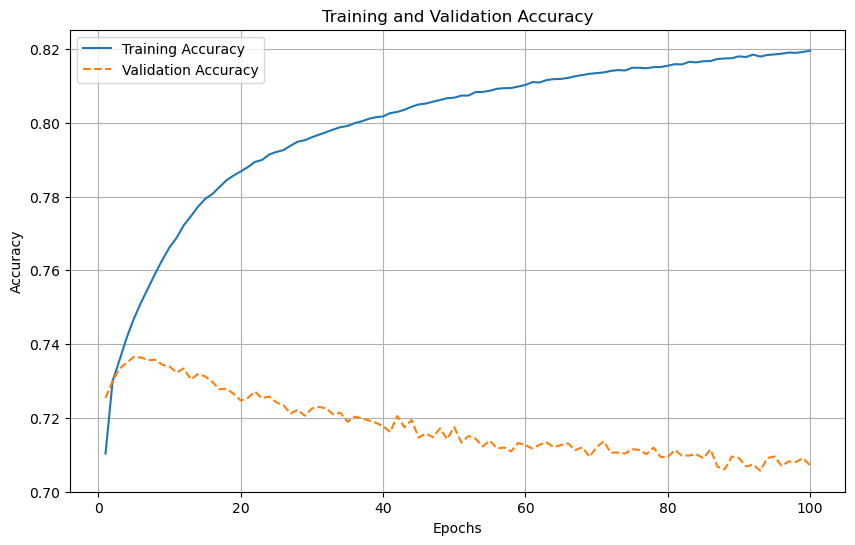

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 788us/step
MAP: 0.573332
NDCG: 1.000000
Precision@K: 0.888655
Recall@K: 0.573332
Model saved as 'ncf_model.keras'


In [26]:
if __name__ == "__main__":    
    
    def build_model(n_users, n_items):
        model = NeuralCollaborativeFiltering(n_users=n_users, n_items=n_items)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    RESUME_TRAINING = False

    model = build_model(n_users, n_items)

    if RESUME_TRAINING and os.path.exists(CHECKPOINT_FILEPATH):
        print("Checkpoint found. Resuming training...")
        model.load_weights(CHECKPOINT_FILEPATH)
    else:
        print("No checkpoint found. Training from scratch.")

    checkpoint_callback = ModelCheckpoint(
        filepath=CHECKPOINT_FILEPATH,
        save_weights_only=True,
        save_best_only=False,
        verbose=1
    )

    user_input = train_data['userID'].values
    item_input = train_data['itemID'].values
    labels = train_data['rating'].values > 3.5

    start_time = time.time()

    history = model.fit(
        [user_input, item_input],
        labels,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=[checkpoint_callback]
    )

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total training time: {elapsed_time:.2f} seconds")

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    with open('user_mapping.pkl', 'wb') as f:
        pickle.dump(user_mapping, f)

    with open('item_mapping.pkl', 'wb') as f:
        pickle.dump(item_mapping, f)

    user_input_test = test_data['userID'].values
    item_input_test = test_data['itemID'].values
    predictions = model.predict([user_input_test, item_input_test])

    test_data['prediction'] = predictions

    eval_map = map(test_data, test_data, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(test_data, test_data, col_prediction='prediction', k=TOP_K)
    eval_precision = precision_at_k(test_data, test_data, col_prediction='prediction', k=TOP_K)
    eval_recall = recall_at_k(test_data, test_data, col_prediction='prediction', k=TOP_K)

    print(
        f"MAP: {eval_map:.6f}\n"
        f"NDCG: {eval_ndcg:.6f}\n"
        f"Precision@K: {eval_precision:.6f}\n"
        f"Recall@K: {eval_recall:.6f}"
    )

    model.save('M:/Movie-Recommendation-Engine/models/ncf_model.keras')
    print("Model saved as 'ncf_model.keras'")